<a href="https://colab.research.google.com/github/tfreyd/11.PopularDataScienceQuestions/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.7.0'

In [2]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 65.5MB/s]


In [4]:
import csv
time_step=[]
sunspots=[]

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

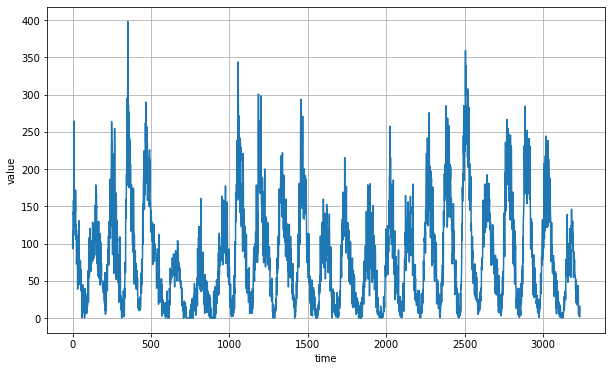

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [6]:
split_time = 3000 
time_train = time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

window_size= 30
batch_size = 32
shuffle_buffer_size = 1000 
def windowed_dataset(series, windows_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1],w[-1]))

  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift= 1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(windows_size))
  ds = ds.batch(batch_size).prefetch(1)

  forecast = model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size=64
batch_size=256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [16]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',activation='relu',
                           input_shape=[None,1]),
    
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x *400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)

model.compile(loss='Huber',
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 4s 25ms/step - loss: 59.2263 - mae: 59.7244 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 31ms/step - loss: 58.2419 - mae: 58.7398 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 30ms/step - loss: 57.9907 - mae: 58.4887 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 30ms/step - loss: 57.7226 - mae: 58.2205 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 30ms/step - loss: 57.4658 - mae: 57.9637 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 29ms/step - loss: 57.2235 - mae: 57.7213 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 56.9421 - mae: 57.4399 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 29ms/step - loss: 56.6369 - mae: 57.1346 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 1s 29ms/step - loss: 56.3261 - mae:

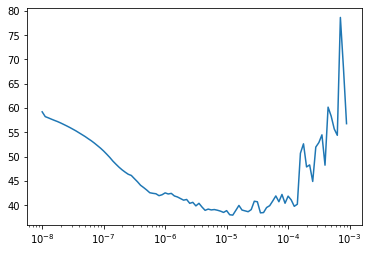

In [17]:
plt.semilogx(history.history['lr'],history.history['loss'])

In [20]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',activation='relu',
                           input_shape=[None,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x *400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)

model.compile(loss='Huber',
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=500)

Epoch 1/500
12/12 [==============================] - 6s 33ms/step - loss: 63.1083 - mae: 63.6064
Epoch 2/500
12/12 [==============================] - 1s 37ms/step - loss: 46.3784 - mae: 46.8765
Epoch 3/500
12/12 [==============================] - 1s 38ms/step - loss: 39.6048 - mae: 40.1018
Epoch 4/500
12/12 [==============================] - 1s 37ms/step - loss: 37.4939 - mae: 37.9903
Epoch 5/500
12/12 [==============================] - 1s 36ms/step - loss: 36.1274 - mae: 36.6238
Epoch 6/500
12/12 [==============================] - 1s 36ms/step - loss: 35.6628 - mae: 36.1588
Epoch 7/500
12/12 [==============================] - 1s 34ms/step - loss: 34.7755 - mae: 35.2709
Epoch 8/500
12/12 [==============================] - 1s 37ms/step - loss: 33.8802 - mae: 34.3759
Epoch 9/500
12/12 [==============================] - 1s 36ms/step - loss: 33.4367 - mae: 33.9322
Epoch 10/500
12/12 [==============================] - 1s 36ms/step - loss: 32.1561 - mae: 32.6514
Epoch 11/500
12/12 [=========